# Imports

In [1]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

import os, pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from math import log
from numpy import array
from numpy import argmax

In [2]:
# seed everything
SEED = 4546
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
TPU= False

# image resolution
IMG_HEIGHT = 256
IMG_WIDTH = 448
N_CHANNELS = 3
# maximum InChI length is 200 to prevent too much padding
MAX_INCHI_LEN = 200

BATCH_SIZE= 30
# ImageNet mean and std to normalize training images accordingly
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Data Pipeline

In [3]:
# dictionary to translate a character to the integer encoding
with open('../input/bmstfrecord-data/vocabulary_to_int.pkl', 'rb') as p:
    vocabulary_to_int= pickle.load(p)
    
# dictionary to decode an integer encoded character back to the character
with open('../input/bmstfrecord-data/int_to_vocabulary.pkl', 'rb') as p:
    int_to_vocabulary= pickle.load(p)

In [4]:
START_TOKEN = tf.constant(vocabulary_to_int.get('<start>'), dtype=tf.int64)
END_TOKEN = tf.constant(vocabulary_to_int.get('<end>'), dtype=tf.int64)
PAD_TOKEN = tf.constant(vocabulary_to_int.get('<pad>'), dtype=tf.int64)

In [5]:
def decode_tfrecord(record_bytes):
    feature= tf.io.parse_single_example(record_bytes,{
        'image': tf.io.FixedLenFeature([], tf.string),
        'InChI': tf.io.FixedLenFeature([MAX_INCHI_LEN], tf.int64)
    })
    # decode the PNG and explicitly reshape to image size (required on TPU)
    image = tf.io.decode_png(feature['image'])    
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 1])
    # normalize according to ImageNet mean and std
    image = tf.cast(image, tf.float32)  / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    
    if TPU: # if running on TPU image needs to be cast to bfloat16
        image = tf.cast(image, TARGET_DTYPE)
    
    InChI = tf.reshape(feature['InChI'], [MAX_INCHI_LEN])
    InChI = tf.cast(InChI, tf.uint8)
    #InChI= tf.one_hot(InChI, depth= 41)
    
    return image, InChI

def get_val_dataset(bs=BATCH_SIZE):
    FNAMES_TRAIN_TFRECORDS = tf.io.gfile.glob('../input/bmstfrecord-data/val/*.tfrecords')
    AUTO= tf.data.experimental.AUTOTUNE
    val_dataset = tf.data.TFRecordDataset(FNAMES_TRAIN_TFRECORDS, num_parallel_reads=AUTO)
    val_dataset = val_dataset.prefetch(AUTO)
    val_dataset = val_dataset.repeat()
    val_dataset = val_dataset.map(decode_tfrecord, num_parallel_calls=AUTO)
    val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
    val_dataset = val_dataset.prefetch(1)
    
    return val_dataset

val_dataset = get_val_dataset()

In [6]:
imgs, lbls = next(iter(val_dataset))
print(f'imgs.shape: {imgs.shape}, lbls.shape: {lbls.shape}')

imgs.shape: (30, 256, 448, 3), lbls.shape: (30, 200)


# Model Config.

In [7]:
VOCAB_SIZE= 41
DECODER_DIM = 512
ATTENTION_UNITS = 256

In [8]:
class Encoderv1(tf.keras.Model):
    """Encoderv1"""
    def __init__(self):
        super(Encoderv1, self).__init__()
        #output (8, 14, 1408)
        self.fea_ext = efn.EfficientNetB2(include_top=False, weights='noisy-student')
        global ENCODER_DIM
        ENCODER_DIM = self.fea_ext.layers[-1].output_shape[-1] 
        self.reshape = tf.keras.layers.Reshape([-1, ENCODER_DIM], name='reshape_featuere_maps')
        self.permuate = tf.keras.layers.Permute([2, 1], name='permutate_features_last')
    def call(self, x, training):
        x = self.fea_ext(x, training=training)
        x = self.reshape(x, training=training)
        x = self.permuate(x, training=training)
        return x

class BahdanauAttention(tf.keras.layers.Layer):
    """BahdanauAttention"""
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1= tf.keras.layers.Dense(units, name='hidden_to_attention_units')
        self.W2= tf.keras.layers.Dense(units, name='encoder_to_attention_units')
        self.V= tf.keras.layers.Dense(1, name='score_to_alpha')
    def call(self, h, encoder_res, training):
        # dense hidden state to attention units size and expand dimension
        hidden_with_time_axis = tf.expand_dims(h, 1)
        hidden_with_time_axis = self.W1(hidden_with_time_axis, training=training)
        # dense features to units size
        encoder_res_dense = self.W2(encoder_res, training=training)
        # add vectors
        score = tf.math.tanh(hidden_with_time_axis + encoder_res_dense)
        score = self.V(score, training=training)
        # create alpha vector size (bs, layers)        
        attention_weights = tf.nn.softmax(score, axis=1)
        # create attention weights (bs, layers)
        context_vector = encoder_res * attention_weights #  tf.expand_dims(attention_weights, axis=2)
        context_vector = tf.reduce_sum(context_vector  , axis=2)
        return context_vector, attention_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, attention_units, encoder_dim, decoder_dim):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.attention_units = attention_units
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        # LSTM hidden and carry state initialization
        self.init_h = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_hidden_init')
        self.init_c = tf.keras.layers.Dense(units=decoder_dim, input_shape=[encoder_dim], name='encoder_res_to_inp_act_init')
        # The LSTM cell
        self.lstm_cell = tf.keras.layers.LSTMCell(decoder_dim, name='lstm_char_predictor')
        # dropout before prediction
        self.drop = tf.keras.layers.Dropout(0.3, name='prediction_dropout')
        # fully connected prediction layer
        self.fcn = tf.keras.layers.Dense(units=vocab_size, input_shape=[decoder_dim], activation='softmax', dtype=tf.float32, name='lstm_output_to_char_probs')
        # character embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, decoder_dim)

        # used for attention
        self.attention = BahdanauAttention(self.attention_units)
    def call(self, char, h, c, enc_output, training):
        
        # embed previous character
        char = self.embedding(char, training=training)
        char = tf.squeeze(char, axis=1)
        #print('------', char.shape)
        # get attention alpha and context vector
        context, _ = self.attention(h, enc_output, training=training)

        # concat context and char to create lstm input
        lstm_input = tf.concat((context, char), axis=-1)
        
        # LSTM call, get new h, c
        _, (h_new, c_new) = self.lstm_cell(lstm_input, (h, c), training=training)
        
        # compute predictions with dropout
        output = self.drop(h_new, training=training)
        output = self.fcn(output, training=training)

        return output, h_new, c_new
    def init_hidden_state(self, encoder_out, training):
        mean_encoder_out = tf.math.reduce_mean(encoder_out, axis=1)
        h = self.init_h(mean_encoder_out, training=training)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out, training=training)
        return h, c

In [9]:
encoder = Encoderv1()
encoder_res = encoder(imgs)
decoder = Decoder(VOCAB_SIZE, ATTENTION_UNITS, ENCODER_DIM, DECODER_DIM)
h, c = decoder.init_hidden_state(encoder_res, training=False)
preds, h, c = decoder(tf.random.uniform((BATCH_SIZE, 1)), h, c, encoder_res)

31784960/31782304 [==============================] - 1s 0us/step


In [10]:
encoder.load_weights('../input/colabmodels-bms/BMS Model/encoder-imgnet-colab.h5')
decoder.load_weights('../input/colabmodels-bms/BMS Model/decoder-imgnet-colab.h5')

# Model Prediction

In [11]:
def get_pred(imgs):
    enc_output = encoder(imgs, training=True)
    h, c = decoder.init_hidden_state(enc_output, training=True)
    dec_input = tf.zeros((imgs.shape[0], 1), tf.uint8)
    predictions_seq = dec_input
    for t in range(1, MAX_INCHI_LEN):
        predictions, h, c = decoder(dec_input, h, c, enc_output, training=False)
        dec_input= tf.expand_dims(tf.argmax(predictions, 1), 1)
        dec_input= tf.cast(dec_input, tf.uint8)
        predictions_seq=  tf.concat([predictions_seq, dec_input], axis=1)
        if t==1:
            predictions_prob= predictions
        else:
            predictions_prob= tf.concat([predictions_prob, predictions], axis=1)
    predictions_prob= tf.reshape(predictions_prob, (predictions_prob.shape[0], (MAX_INCHI_LEN-1), VOCAB_SIZE))
    return predictions_seq, predictions_prob

In [12]:
def convert(inp):
    string=''
    for i in inp[1:]:
        if i== 1:
            break
        string+= int_to_vocabulary[i]
    return string

def process_pred(pred):
    str_list=[]
    for i in range(pred.shape[0]):
        str_list.append(convert(pred[i].numpy()))
    return str_list 

In [13]:
def show(img, label, pred, bs_seq):
    print('LABEL--',label)
    print('\n')
    print('PREDICTED--',pred)
    print('\n')
    print('BEAM SEARCH--',bs_seq)
    plt.figure(figsize=(8, 8))
    plt.imshow(-imgs[0])
    plt.yticks([]);plt.xticks([])
    plt.show()
    
# beam search
def beam_search_decoder(data, k):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

def dense_to_sparse(dense):
    ones = tf.ones(dense.shape)
    indices = tf.where(ones)
    values = tf.gather_nd(dense, indices)
    sparse = tf.SparseTensor(indices, values, dense.shape)
    
    return sparse

def get_levenshtein_distance(preds, lbls):
    preds = tf.cast(preds, tf.int64)

    preds = tf.where(tf.not_equal(preds, START_TOKEN) & tf.not_equal(preds, END_TOKEN) & tf.not_equal(preds, PAD_TOKEN), preds, y=0)
    lbls = tf.cast(lbls, tf.int64)
    lbls = tf.where(tf.not_equal(lbls, START_TOKEN) & tf.not_equal(lbls, END_TOKEN) & tf.not_equal(lbls, PAD_TOKEN), lbls, y=0)
    
    preds_sparse = dense_to_sparse(preds)
    lbls_sparse = dense_to_sparse(lbls)

    batch_distance = tf.edit_distance(preds_sparse, lbls_sparse, normalize=False)
    mean_distance = tf.math.reduce_mean(batch_distance)
    
    return mean_distance

# Final Results

In [14]:
predictions_seq, predictions_prob= get_pred(imgs)
predictions_seq.shape, predictions_prob.shape

(TensorShape([30, 200]), TensorShape([30, 199, 41]))

LABEL-- C31H27ClN2O7S/c1-6-40-30(37)26-17(3)33-31-34(27(26)22-14-19(32)8-11-23(22)38-4)28(35)25(42-31)15-20-9-12-24(41-20)21-10-7-18(13-16(21)2)29(36)39-5/h7-15,27H,6H2,1-5H3/b25-15-/t27-/m0/s1


PREDICTED-- C31H27ClN2O7S/c1-6-40-29(36)26-17(3)33-31-34(27(26)24-14-19(32)9-12-23(22)38-5)28(35)24(42-31)15-20-1-11-22(41-20)20-10-7-17(13-1((2))2)29(36)40-4/h7-15,27H,6H2,1-5H3/b26-15-/t27-/m0/s1


BEAM SEARCH-- 31H27ClN2O7S/c1-6-40-29(36)26-17(3)33-31-34(27(26)24-14-19(32)9-12-23(22)38-5)29(35)24(42-31)15-20-1-11-22(41-20)20-10-7-17(13-1((2))2)29(36)40-4/h7-15,27H,6H2,1-5H3/b26-15-/t27-/m0/s1


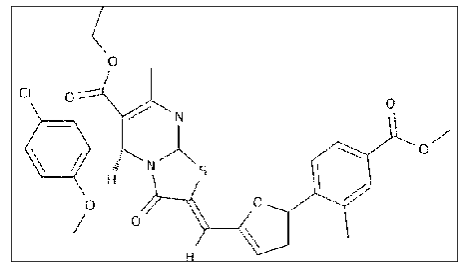

LD for PREDICTED- 19.0
LD for BEAM SEARCH- 20.0
***********************************************

LABEL-- C26H25N3O2S2/c1-31-21-11-4-3-9-19(21)27-26(30)29-16-18-17-8-2-5-12-22(17)33-25(18)28-14-6-10-20(28)24(29)23-13-7-15-32-23/h3-4,6-7,9-11,13-15,24H,2,5,8,12,16H2,1H3,(H,27,30)


PREDICTED-- C26H25N3O2S2/c1-31-20-11-4-2-9-18(21)27-26(30)29-16-19-17-8-2-5-12-22(17)33-25(22)28-14-1-11-11-22-22-22-2--1-13-13-23-22/h2-4,7,8-11,14,15,2,H,,,,,,,11,1,HH,1H,,,,,2,,3<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


BEAM SEARCH-- 26H25N3O2S2/c1-31-20-11-4-2-9-18(21)27-26(30)29-16-19-17-8-2-5-12-22(17)33-25(22)28-14-1-11-1--22-22-22-2--1-13-13-23-22/h2-4,7,8-11,14,15,2,H,,,,,,,11,1,HH,1H,,,,,2,,3<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


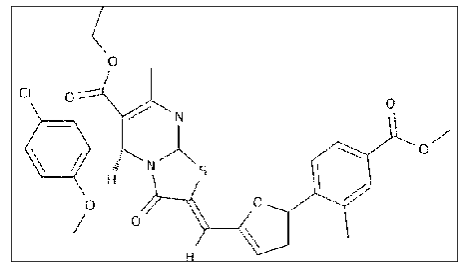

LD for PREDICTED- 46.0
LD for BEAM SEARCH- 46.0
***********************************************

LABEL-- C23H30N2O4S/c1-3-29-21-13-15-22(16-14-21)30(27,28)25(20-11-9-18(2)10-12-20)17-23(26)24-19-7-5-4-6-8-19/h9-16,19H,3-8,17H2,1-2H3,(H,24,26)


PREDICTED-- C23H30N2O4S/c1-3-29-21-13-15-22(16-14-21)30(27,28)25(20-11-9-18(2)10-12-20)17-23(26)24-19-7-5-4-6-8-19/h9-16,19H,3-8,17H2,1-2H3,(H,24,26)


BEAM SEARCH-- 23H30N2O4S/c1-3-29-21-13-15-22(16-14-21)30(27,28)25(21-11-9-18(2)10-12-20)17-23(26)24-19-7-5-4-6-8-19/h9-16,19H,3-8,17H2,1-2H3,(H,24,26)


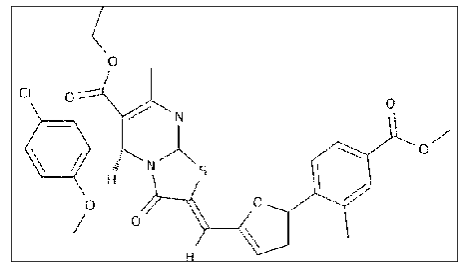

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C20H20ClN3O4/c1-11-16(19(25)23-14-9-5-4-8-13(14)21)17(24-20(26)22-11)12-7-6-10-15(27-2)18(12)28-3/h4-10,17H,1-3H3,(H,23,25)(H2,22,24,26)


PREDICTED-- C20H20ClN3O4/c1-11-15(19(25)23-14-9-5-4-8-13(14)21)17(24-20(26)22-11)12-7-6-10-15(27-2)18(12)28-3/h4-10,17H,1-3H3,(H,23,25)(H2,22,24,26)


BEAM SEARCH-- 20H20ClN3O4/c1-11-15(19(25)23-14-9-5-4-8-13(14)21)17(24-20(26)23-11)12-7-6-10-15(27-2)18(12)28-3/h4-10,17H,1-3H3,(H,23,25)(H2,22,24,26)


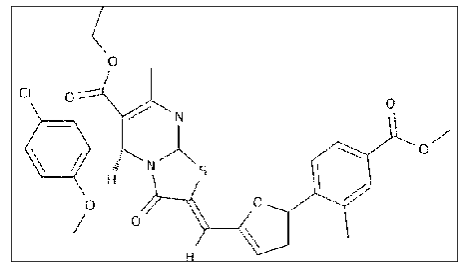

LD for PREDICTED- 1.0
LD for BEAM SEARCH- 2.0
***********************************************

LABEL-- C16H14F3NO3/c1-22-15(21)10-6-7-12(17)13(8-10)20-9-11-4-2-3-5-14(11)23-16(18)19/h2-8,16,20H,9H2,1H3


PREDICTED-- C16H14F3NO3/c1-22-15(21)10-6-7-12(17)13(8-10)20-9-11-4-2-3-5-14(11)23-16(18)19/h2-8,16,20H,9H2,1H3


BEAM SEARCH-- 16H14F3NO3/c1-22-15(21)11-6-7-12(17)13(8-10)20-9-11-4-2-3-5-14(11)23-16(18)19/h2-8,16,20H,9H2,1H3


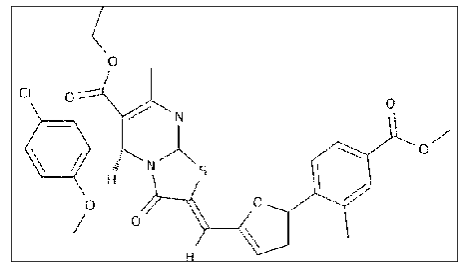

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C11H9IN2/c12-11-10(13-6-7-14-11)8-9-4-2-1-3-5-9/h1-7H,8H2


PREDICTED-- C11H9IN2/c12-11-10(13-6-7-14-11)8-9-4-2-1-3-5-9/h1-7H,8H2


BEAM SEARCH-- 11H9IN2/c12-11-10(13-7-7-14-11)8-9-4-2-1-3-5-9/h1-7H,8H2


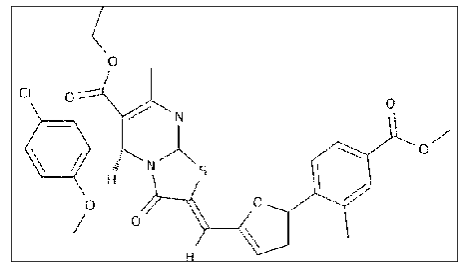

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C11H12BrN7O/c1-7(8-2-4-9(12)5-3-8)14-15-10(20)6-19-17-11(13)16-18-19/h2-5,14H,1,6H2,(H2,13,17)(H,15,20)


PREDICTED-- C11H14BrN7O/c1-7(8-2-4-9(12)5-3-8)14-15-10(20)6-19-17-11(13)16-18-19/h2-5,7,14H,6H2,1H3,(H2,13,19)(H,15,20)


BEAM SEARCH-- 11H14BrN7O/c1-7(8-2-4-9(12)5-3-8)14-15-10(20)6-19-17-11(13)16-18-19/h2-5,7,14H,6H2,1H3,(H2,13,18)(H,15,20)


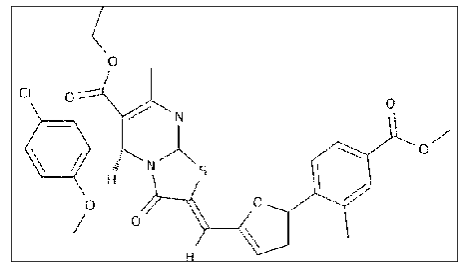

LD for PREDICTED- 13.0
LD for BEAM SEARCH- 13.0
***********************************************

LABEL-- C22H30N4O5S/c1-3-22(2)20(28)26(21(29)23-22)24-19(27)16-10-12-25(13-11-16)32(30,31)18-9-8-15-6-4-5-7-17(15)14-18/h8-9,14,16H,3-7,10-13H2,1-2H3,(H,23,29)(H,24,27)/t22-/m0/s1


PREDICTED-- C22H30N4O5S/c1-3-22(2)20(28)26(21(29)23-22)24-19(27)16-10-12-25(13-11-16)32(30,31)18-9-8-15-6-4-5-7-17(15)14-18/h8-9,14,16H,3-7,10-13H2,1-2H3,(H,23,29)(H,24,27)/t22-/m0/s1


BEAM SEARCH-- 22H30N4O5S/c1-3-22(2)20(28)26(21(29)23-22)24-19(27)16-10-12-25(13-11-16)32(30,31)18-9-8-15-6-4-5-7-17(15)14-18/h8-9,14,16H,3-7,10-13H2,1-2H3,(H,23,28)(H,24,27)/t22-/m0/s1


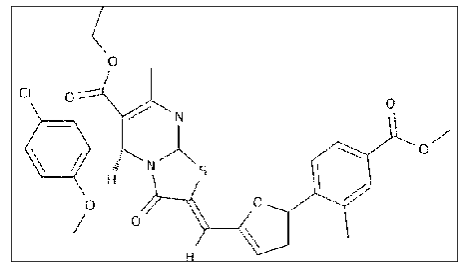

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C19H29N5O/c1-5-13(3)24-18-16(11-21-24)15(10-12(2)22-18)19(25)23-9-7-6-8-17(23)14(4)20/h10-11,13-14,17H,5-9,20H2,1-4H3


PREDICTED-- C19H29N5O/c1-5-13(3)24-18-16(11-21-24)15(10-12(4)22-18)19(25)23-9-7-6-8-17(23)14(4)20/h10-12,14,17H,5-9,20H2,1-4H3


BEAM SEARCH-- 19H29N5O/c1-5-13(3)24-18-16(11-21-24)15(10-12(3)22-18)19(25)23-9-7-6-8-17(23)14(4)20/h10-12,14,17H,5-9,20H2,1-4H3


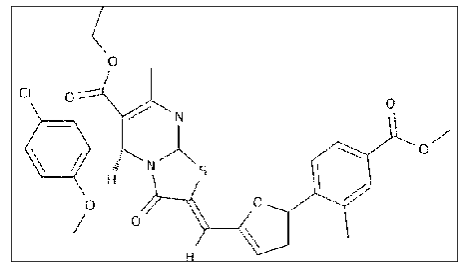

LD for PREDICTED- 8.0
LD for BEAM SEARCH- 8.0
***********************************************

LABEL-- C20H17BrCl2N2O4/c1-11-14(22)3-2-4-17(11)25-9-12(7-19(25)27)20(28)29-10-18(26)24-16-6-5-13(21)8-15(16)23/h2-6,8,12H,7,9-10H2,1H3,(H,24,26)/t12-/m0/s1


PREDICTED-- C19H15BrCl2N2O4/c20-12-4-5-16(15(22)8-12)23-17(25)10-28-20(27)11-6-18(26)24(9-11)14-3-1-2-13(21)8-14/h1-h,7-8,11H,,,,-11H2,(H,22,2,)/t1/-/m//s1


BEAM SEARCH-- 19H15BrCl2N2O4/c20-12-4-5-16(15(22)8-12)23-17(25)10-28-20(27)11-6-18(26)24(9-11)14-3-1-2-13(21)8-14/h1-h,7-8,11H,,,,-11H2,(H,22,2,)/t11-/m//s1


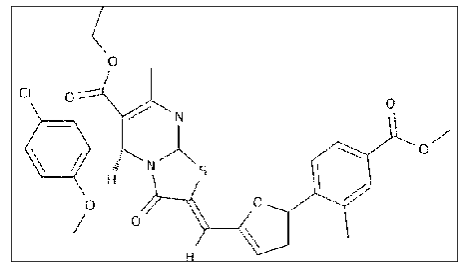

LD for PREDICTED- 72.0
LD for BEAM SEARCH- 72.0
***********************************************

LABEL-- C20H19BrN4O3/c21-15-5-3-14(4-6-15)20(8-1-9-20)19-24-18(28-25-19)13-2-7-16(23-12-13)17(27)22-10-11-26/h2-7,12,26H,1,8-11H2,(H,22,27)


PREDICTED-- C20H19BrN4O3/c21-15-5-2-13(3-6-15)20(8-1-9-20)19-24-17(28-25-19)14-3-6-16(23-12-14)17(27)22-10-11-26/h2-7,12,26H,1,8-11H2,(H,22,27)


BEAM SEARCH-- 20H19BrN4O3/c21-15-5-2-13(3-6-15)20(8-1-9-20)19-24-17(28-25-19)14-3-7-16(23-12-14)17(27)22-10-11-26/h2-7,12,26H,1,8-11H2,(H,22,27)


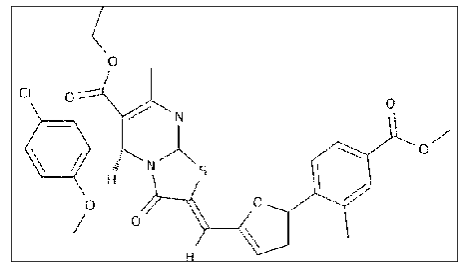

LD for PREDICTED- 8.0
LD for BEAM SEARCH- 7.0
***********************************************

LABEL-- C12H20N4OS/c1-9-7-16(5-6-17-9)12(13)14-4-3-11-10(2)15-8-18-11/h8-9H,3-7H2,1-2H3,(H2,13,14)


PREDICTED-- C12H20N4OS/c1-9-7-16(5-6-17-9)12(13)14-4-3-11-10(2)15-8-18-11/h8-9H,3-7H2,1-2H3,(H2,13,14)


BEAM SEARCH-- 12H20N4OS/c1-9-7-16(5-6-17-9)12(13)14-4-3-11-10(2)15-8-18-11/h8,9H,3-7H2,1-2H3,(H2,13,14)


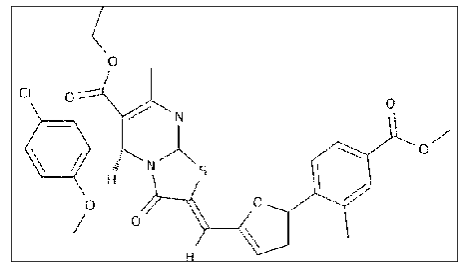

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C12H13N3OS/c1-16-11-3-2-9(12(13)17)6-10(11)7-15-5-4-14-8-15/h2-6,8H,7H2,1H3,(H2,13,17)


PREDICTED-- C12H13N3OS/c1-16-11-3-2-9(12(13)17)6-10(11)7-15-5-4-14-8-15/h2-6,8H,7H2,1H3,(H2,13,17)


BEAM SEARCH-- 12H13N3OS/c1-16-11-3-2-9(12(14)17)6-10(11)7-15-5-4-14-8-15/h2-6,8H,7H2,1H3,(H2,13,17)


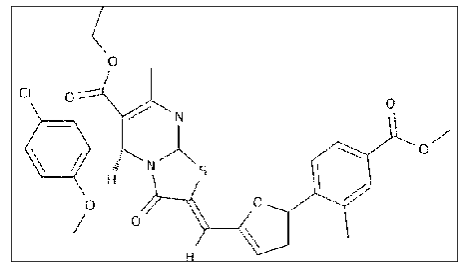

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C17H22ClN3O/c1-3-9-20(10-4-2)17(22)15-11-19-21(13-15)12-14-7-5-6-8-16(14)18/h5-8,11,13H,3-4,9-10,12H2,1-2H3


PREDICTED-- C17H22ClN3O/c1-3-9-20(10-4-2)17(22)15-11-19-21(12-15)12-14-7-5-6-8-16(14)18/h5-8,11,13H,3-4,9-10,12H2,1-2H3


BEAM SEARCH-- 17H22ClN3O/c1-3-9-20(10-4-2)17(22)15-11-19-21(13-15)12-14-7-5-6-8-16(14)18/h5-8,11,13H,3-4,9-10,12H2,1-2H3


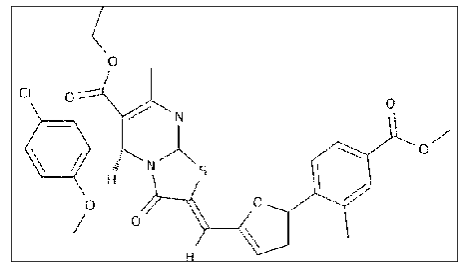

LD for PREDICTED- 1.0
LD for BEAM SEARCH- 0.0
***********************************************

LABEL-- C23H27NO5/c1-14(2)17-6-9-20(10-7-17)24-23(27)16(4)29-22(26)13-19-12-18(15(3)25)8-11-21(19)28-5/h6-12,14,16H,13H2,1-5H3,(H,24,27)/t16-/m1/s1


PREDICTED-- C23H27NO5/c1-14(2)17-6-9-20(10-7-17)24-23(27)16(4)29-22(26)13-19-12-18(15(3)25)8-11-21(19)28-5/h6-12,14-15H,13H2,1-5H3,(H,24,27)/t16-/m0/s1


BEAM SEARCH-- 23H27NO5/c1-14(2)17-6-9-20(10-7-17)24-23(27)16(4)29-22(26)13-19-12-18(15(3)25)8-11-21(19)28-5/h6-12,14-15H,13H2,1-5H3,(H,24,27)/t16-/m1/s1


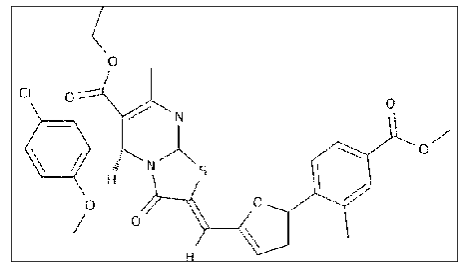

LD for PREDICTED- 3.0
LD for BEAM SEARCH- 2.0
***********************************************

LABEL-- C14H8BrClFNO3/c15-9-6-7(4-5-10(9)16)13(19)18-12-8(14(20)21)2-1-3-11(12)17/h1-6H,(H,18,19)(H,20,21)


PREDICTED-- C14H8BrClFNO3/c15-9-6-7(4-5-10(9)16)13(19)18-12-8(14(20)21)2-1-3-11(12)17/h1-6H,(H,18,19)(H,20,21)


BEAM SEARCH-- 14H8BrClFNO3/c15-9-6-7(4-5-10(9)16)12(19)18-12-8(14(20)21)2-1-3-11(12)17/h1-6H,(H,18,19)(H,20,21)


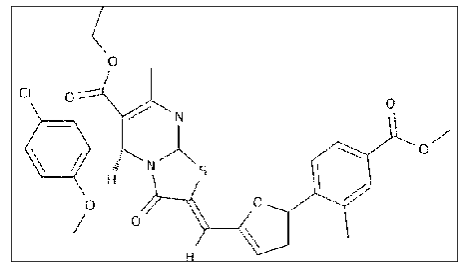

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C23H31N5O3/c1-13-11-28(12-14(2)30-13)22-24-10-16-18(8-23(3,4)9-19(16)26-22)25-21(29)17-7-20(31-27-17)15-5-6-15/h7,10,13-15,18H,5-6,8-9,11-12H2,1-4H3,(H,25,29)/t13-,14-,18-/m1/s1


PREDICTED-- C23H31N5O3/c1-13-11-28(12-14(2)30-13)22-24-9-16-17(8-22(3,4)10-18(17)25-19)25-21(29)18-7-19(31-27-18)15-5-6-15/h7,1,113-15,18H,5-6,8-1,11212,1-HH,,H,,2,29)/t11-,14-,11//m1/s1


BEAM SEARCH-- 23H31N5O3/c1-13-11-28(12-14(2)30-13)22-24-9-16-17(8-22(3,4)10-18(17)25-19)25-21(29)18-7-19(31-27-18)15-5-6-15/h7,1,113-15,18H,5-6,8-1,11212,1-HH3,H,,2,29)/t11-,14-,11//m1/s1


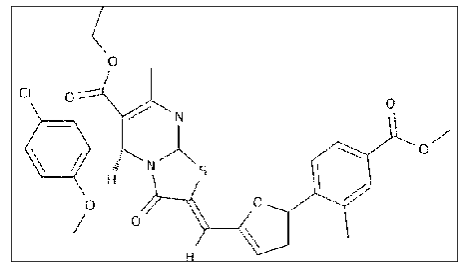

LD for PREDICTED- 32.0
LD for BEAM SEARCH- 31.0
***********************************************

LABEL-- C13H10N2O2/c16-7-8-5-6-11-12(13(8)17)15-10-4-2-1-3-9(10)14-11/h1-6,8,16H,7H2


PREDICTED-- C13H10N2O2/c16-7-8-5-6-11-13(12(8)17)15-10-4-2-1-3-9(10)14-11/h1-6,8,16H,7H2


BEAM SEARCH-- 13H10N2O2/c16-7-8-5-6-11-12(12(8)17)15-10-4-2-1-3-9(10)14-11/h1-6,8,16H,7H2


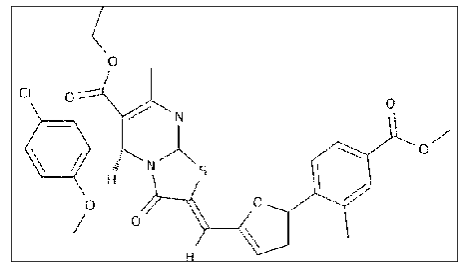

LD for PREDICTED- 2.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C24H23Cl2N5O4S/c1-13-21-23(30-29-13)27-22(28-24(21)35-18-9-7-17(32)8-10-18)14-2-5-16(6-3-14)31-36(33,34)20-12-15(25)4-11-19(20)26/h2-6,11-12,17-18,31-32H,7-10H2,1H3,(H,27,28,29,30)


PREDICTED-- C24H23Cl2N5O4S/c1-13-21-23(28-24-10-1--1--1-1--1--2--2--2--2-22-22-22-21--------1------15)31-33(33,33)11-11-1-(1-)----18(18)18-22/h2-6,11-12,17-18,32-32H,7-10H2,1H3,(H,27,28,29,30)


BEAM SEARCH-- 24H23Cl2N5O4S/c1-13-21-23(28-24-10-1--1--1-1--1--2--2--2--2-22-22-22-21--------1------15)31-33(33,33)21-11-1-(1-)----18(18)18-22/h2-6,11-12,17-18,32-32H,7-10H2,1H3,(H,27,28,29,30)


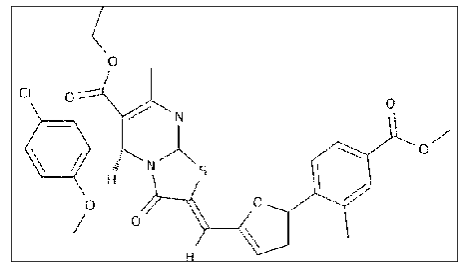

LD for PREDICTED- 63.0
LD for BEAM SEARCH- 62.0
***********************************************

LABEL-- C17H15NO3/c1-4-18-9(2)13(10(3)19)14-15(18)17(21)12-8-6-5-7-11(12)16(14)20/h5-8H,4H2,1-3H3


PREDICTED-- C17H15NO3/c1-4-18-10(2)13(9(2)19)14-15(18)17(21)12-8-6-5-7-11(12)16(14)20/h5-8H,4H2,1-3H3


BEAM SEARCH-- 17H15NO3/c1-4-18-10(2)13(1(2)19)14-15(18)17(21)12-8-6-5-7-11(12)16(14)20/h5-8H,4H2,1-3H3


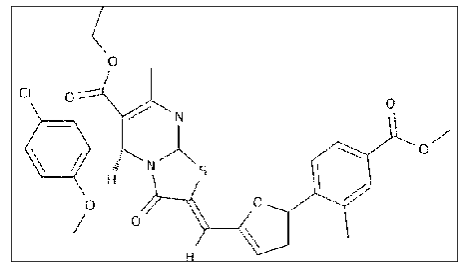

LD for PREDICTED- 5.0
LD for BEAM SEARCH- 4.0
***********************************************

LABEL-- C20H17F2N5O2/c21-15-6-3-5-13(10-15)18-19(28)23-8-9-27(18)20(29)17-12-26(25-24-17)11-14-4-1-2-7-16(14)22/h1-7,10,12,18H,8-9,11H2,(H,23,28)/t18-/m1/s1


PREDICTED-- C20H17F2N5O2/c21-15-6-3-5-13(10-15)18-19(28)23-8-9-27(18)20(29)17-12-26(25-24-17)11-13-4-1-2-7-16(14)22/h1-7,10,12,18H,8-9,11H2,(H,23,28)/t18-/m0/s1


BEAM SEARCH-- 20H17F2N5O2/c21-15-6-3-5-14(10-15)18-19(28)23-8-9-27(18)20(29)17-12-26(25-24-17)11-13-4-1-2-7-16(14)22/h1-7,10,12,18H,8-9,11H2,(H,23,28)/t18-/m0/s1


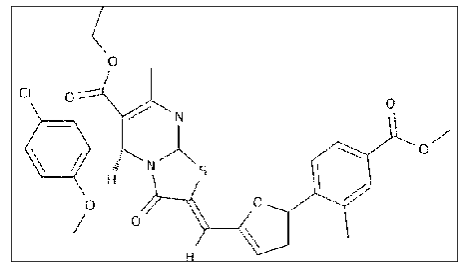

LD for PREDICTED- 2.0
LD for BEAM SEARCH- 3.0
***********************************************

LABEL-- C27H29NO5/c1-19-16-24(25(29)22-11-13-23(32-4)14-12-22)28(17-19)15-5-6-20-7-9-21(10-8-20)18-33-27(2,3)26(30)31/h5-14,16-17H,15,18H2,1-4H3,(H,30,31)/b6-5+


PREDICTED-- C27H29NO5/c1-19-16-24(24(29)22-11-13-23(32-4)14-12-22)28(17-20)15-5-6-20-7-9-21(10-8-20)18-33-27(2,3)26(30)31/h5-14,16-17H,15,18H2,1-4H3,(H,30,31)/b6-4+


BEAM SEARCH-- 27H29NO5/c1-19-16-24(24(29)22-11-13-23(32-4)14-12-22)28(17-20)15-5-6-20-7-9-21(10-8-20)18-33-27(2,3)26(30)31/h5-14,16-17H,15,18H2,1-4H3,(H,30,31)/b5-4+


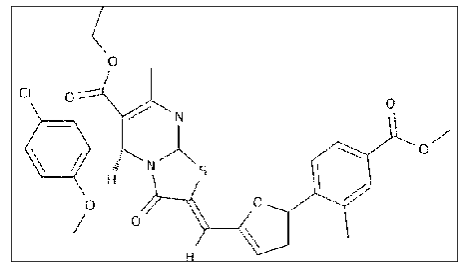

LD for PREDICTED- 4.0
LD for BEAM SEARCH- 5.0
***********************************************

LABEL-- C15H30N2/c1-3-13(2)17-11-7-10-16-15(12-17)14-8-5-4-6-9-14/h13-16H,3-12H2,1-2H3


PREDICTED-- C15H30N2/c1-3-13(2)17-11-7-10-16-15(12-17)14-8-5-4-6-9-14/h13-16H,3-12H2,1-2H3


BEAM SEARCH-- 15H30N2/c1-3-13(2)17-11-6-10-16-15(12-17)14-8-5-4-6-9-14/h13-16H,3-12H2,1-2H3


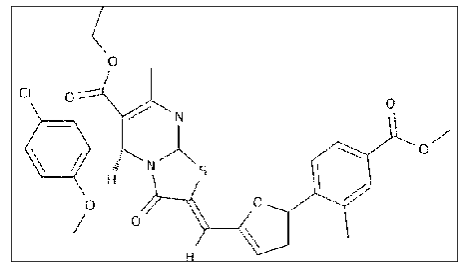

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C30H35Cl2N3O5S/c1-6-25(29(37)33-30(2,3)4)34(19-21-15-17-22(40-5)18-16-21)27(36)20-35(26-14-10-13-24(31)28(26)32)41(38,39)23-11-8-7-9-12-23/h7-18,25H,6,19-20H2,1-5H3,(H,33,37)/t25-/m1/s1


PREDICTED-- C30H35Cl2N3O5S/c1-6-25(29(37)33-30(2,3)4)34(19-21-15-17-22(39-5)18-16-21)27(36)20-35(24-13-10-13-24(31)28(26)32)41(38,39)24-12-8-7-9-13-24/h7-18,25H,6,10-20H2,1-5H3,(H,33,37)/t25-/m0/s1


BEAM SEARCH-- 30H35Cl2N3O5S/c1-6-25(29(37)33-30(2,3)4)34(19-21-15-17-22(49-5)18-16-21)27(36)20-35(24-13-10-13-24(31)28(26)32)41(38,39)24-12-8-7-9-13-24/h7-18,25H,6,10-20H2,1-5H3,(H,33,37)/t25-/m0/s1


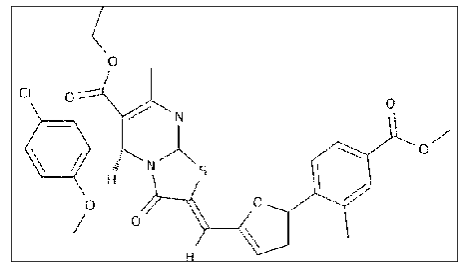

LD for PREDICTED- 10.0
LD for BEAM SEARCH- 9.0
***********************************************

LABEL-- C27H26Cl2N2O6S/c1-18-2-7-22(8-3-18)38(35,36)31-12-10-30(11-13-31)27(34)23-14-19(15-26(32)33)4-9-25(23)37-17-20-5-6-21(28)16-24(20)29/h2-9,14,16H,10-13,15,17H2,1H3,(H,32,33)


PREDICTED-- C27H26Cl2N2O6S/c1-18-2-7-22(8-3-18)38(35,36)31-12-10-30(11-13-31)27(34)23-14-19(16-26(32)33)4-9-25(23)37-17-20-4-6-21(28)16-24(20)29/h2-9,14-15H,10-13,16-17H2,1H3,(H,32,33)


BEAM SEARCH-- 27H26Cl2N2O6S/c1-18-2-7-22(8-3-18)38(35,36)31-12-10-30(11-13-31)27(34)23-14-19(16-26(32)33)4-9-25(23)37-17-20-5-6-21(28)16-24(20)29/h2-9,14-15H,10-13,16-17H2,1H3,(H,32,33)


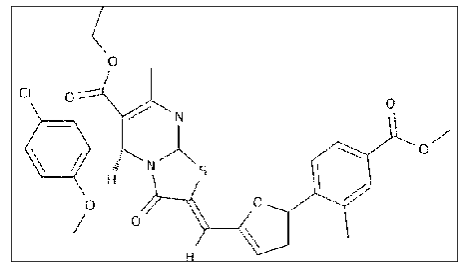

LD for PREDICTED- 6.0
LD for BEAM SEARCH- 5.0
***********************************************

LABEL-- C13H17ClN2/c1-9-6-7-11(14)8-12(9)16-13(15)10-4-2-3-5-10/h6-8,10H,2-5H2,1H3,(H2,15,16)


PREDICTED-- C13H17ClN2/c1-9-6-7-11(14)8-12(9)16-13(15)10-4-2-3-5-10/h6-8,10H,2-5H2,1H3,(H2,15,16)


BEAM SEARCH-- 13H17ClN2/c1-9-6-7-11(14)8-12(9)16-13(15)10-4-2-3-5-10/h6-8,10H,2-5H2,1H3,(H3,15,16)


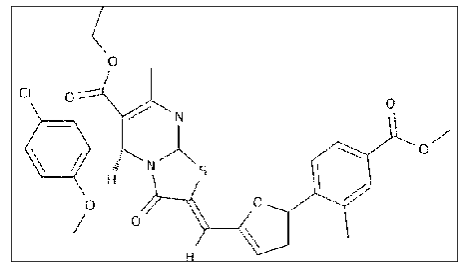

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************

LABEL-- C32H22Cl2N4O5/c1-41-26-12-7-13-27-22(26)16-28(43-27)31-37-25-11-6-5-10-21(25)32(40)38(31)35-17-19-14-23(33)30(24(34)15-19)42-18-29(39)36-20-8-3-2-4-9-20/h2-17H,18H2,1H3,(H,36,39)


PREDICTED-- C32H22Cl2N4O5/c1-42-26-12-7-11-25-24(26)19-39(44-27)31-36-25-11-6-6-12-27(25)38(31)33(30)39)17-19-14-23(33)29(24(33)14-19)41-18-29(39)36-20-8-3-2-4-9-20/h2-17H,18H2,1H3,(H,36,39)


BEAM SEARCH-- 32H22Cl2N4O5/c1-42-26-12-7-11-25-24(26)19-39(44-27)31-36-25-11-6-6-12-27(25)38(33)33(30)39)17-19-14-23(33)29(24(33)14-19)41-18-29(39)36-20-8-3-2-4-9-20/h2-17H,18H2,1H3,(H,36,39)


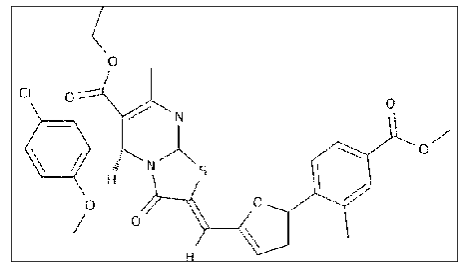

LD for PREDICTED- 24.0
LD for BEAM SEARCH- 24.0
***********************************************

LABEL-- C23H14BrNO3/c24-15-8-6-7-14(13-15)20-19-21(26)17-11-4-5-12-18(17)28-22(19)23(27)25(20)16-9-2-1-3-10-16/h1-13,20H


PREDICTED-- C23H14BrNO3/c24-15-8-6-7-14(13-15)19-19-21(26)17-11-4-5-12-18(17)28-22(19)23(27)25(20)16-9-2-1-3-10-16/h1-13,20H


BEAM SEARCH-- 23H14BrNO3/c24-15-8-6-7-14(13-15)19-18-21(26)17-11-4-5-12-18(17)28-22(19)23(27)25(20)16-9-2-1-3-10-16/h1-13,20H


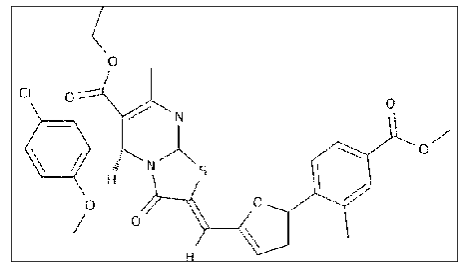

LD for PREDICTED- 2.0
LD for BEAM SEARCH- 3.0
***********************************************

LABEL-- C6H8Cl2O2/c1-3-10-6(8)4(2)5(7)9/h3H2,1-2H3/b6-4-


PREDICTED-- C6H8Cl2O2/c1-3-10-6(8)4(2)5(8)9/h4H,3H2,1-2H3/<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


BEAM SEARCH-- 6H8Cl2

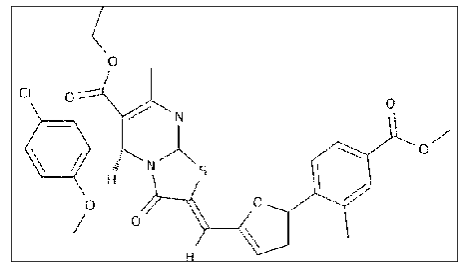

LD for PREDICTED- 9.0
LD for BEAM SEARCH- 10.0
***********************************************

LABEL-- C17H23FN4O2/c1-12(2)16-19-17(20-24-16)22-9-7-21(8-10-22)11-13-5-4-6-14(23-3)15(13)18/h4-6,12H,7-11H2,1-3H3


PREDICTED-- C17H23FN4O2/c1-12(2)16-19-17(20-24-16)22-9-7-21(8-10-22)11-13-5-4-6-14(23-3)15(13)18/h4-6,12H,7-11H2,1-3H3


BEAM SEARCH-- 17H23FN4O2/c1-12(2)16-19-17(21-24-16)22-9-7-21(8-10-22)11-13-5-4-6-14(23-3)15(13)18/h4-6,12H,7-11H2,1-3H3


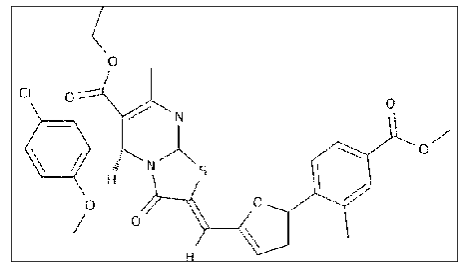

LD for PREDICTED- 0.0
LD for BEAM SEARCH- 1.0
***********************************************



In [15]:
predictions_seq, predictions_prob= get_pred(imgs)
for i in range(BATCH_SIZE):
    show(imgs[i], convert(lbls[i].numpy()),convert(predictions_seq[i].numpy()),
                     convert(beam_search_decoder(predictions_prob[i], 4)[1][0]))
    print('LD for PREDICTED-', get_levenshtein_distance(predictions_seq[i][tf.newaxis, ],
                                    lbls[i][tf.newaxis, ]).numpy())
    print('LD for BEAM SEARCH-', get_levenshtein_distance(np.array([beam_search_decoder(predictions_prob[i], 4)[1][0]]),
                                    lbls[i][tf.newaxis, 1:]).numpy())
    print('***********************************************\n')

In [16]:
#(20, 199, 41)
#tf.reshape(predictions_prob, (predictions_prob.shape[0], (MAX_INCHI_LEN-1), VOCAB_SIZE))

In [17]:
# i= 18
# result = beam_search_decoder(predictions_prob[i], 6)
# # print result
# for seq in result:
#     f = convert(seq[0])
#     print('C'+ f)
#     print(convert(predictions_seq.numpy()[i])[1:]==f)

In [18]:
# predictions_seq, predictions_prob= get_pred(imgs)
# for i in range(BATCH_SIZE):
#     show(imgs[i], convert(lbls[i].numpy()),convert(predictions_seq[i].numpy()),
#                      convert(beam_search_decoder(predictions_prob[i], 2)[1][0]))
#     print('***********************************************\n')